In [79]:
import rasterio
import pandas as pd
import numpy as np
import os
#import geopandas as gpd

import matplotlib.pyplot as plt

%matplotlib inline

# Reference: https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html

# Function for Processing LST Raster Files

In [86]:
def proc_lst(b10_file_loc, qa_pixel_file_loc, output_file_loc):
    '''
    Takes raw LST input from Analysis Ready Data (C2) Earth Explorer and
    the QA_Pixel file, both as rasters (TIF) and outputs a raster file
    for land surface temperature in Celsius, with nodata for missing or
    cloud-influenced pixels
    '''
    # Read in input files
    b10_file = rasterio.open(b10_file_loc) 
    clouds_file = rasterio.open(qa_pixel_file_loc)
    
    # load in data, starting from index 1 (band)
    b10 =  b10_file.read(1)    # This is a numpy array
    clouds =  clouds_file.read(1)

    #reclassify all values in the clouds raster that are not "clear" (21824) to 0:
    clouds_bin = np.where(clouds != 21824, 0, clouds)
    clouds_bin = np.where(clouds_bin == 21824, 1, clouds_bin)
    
    #multiply the two arrays together
    b10_clouds = np.multiply(b10,clouds_bin)
    b10_clouds = np.where(b10_clouds == 0, np.nan, b10_clouds)
    
    # convert with USGS multiplicative/additive factors and from K to C
    lst_c = (b10_clouds*0.00341802 + 149) - 273.1
    
    
    # Edit metadata like a dictionary in python to write to raster file:
    out_meta = b10_file.meta.copy()
    out_meta.update({'driver':'GTiff',
                 'width':b10_file.shape[1],
                 'height':b10_file.shape[0],
                 'count':1,
                 'dtype':'float64',
                 'crs':b10_file.crs, 
                 'transform':b10_file.transform,
                 'nodata':np.nan})
    
    with rasterio.open(output_file_loc, 'w', **out_meta) as dst:
        dst.write_band(1, lst_c.astype(rasterio.float64))
    
    

In [90]:
# Test the function -- this should work.

proc_lst('/home/tclim/Downloads/August Temp Data-20220310T171343Z-001/August Temp Data/8_13_21 Temps.TIF',
         '../data/LC08_CU_024013_20210813_20210822_02_QA_PIXEL.TIF',
        './lst_c_20210813.TIF')

# Testing

In [4]:
b10_file = rasterio.open('../data/LC09_CU_024013_20220213_20220218_02_ST_B10.TIF') # This is from 2/18/2022 WINTER
clouds_file = rasterio.open('../data/LC08_CU_024013_20210813_20210822_02_QA_PIXEL.TIF')

In [7]:
# Output information about files
print(b10_file.crs)
print(b10_file.shape)


PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
(5000, 5000)


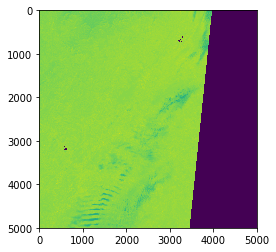

In [69]:
# load in data, starting from index 1 (band)
b10 =  b10_file.read(1)    # This is a numpy array

# 
plt.imshow(b10)

In [70]:
print(np.min(b10))
print(np.max(b10))
print(np.max(b10)* 0.00341802 + 149 - 273.1)

0
47345
37.72615689999998


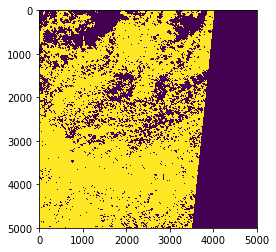

In [29]:
# load in data, starting from index 1 (band)
clouds =  clouds_file.read(1)

#reclassify all values that are not "clear" (21824) to 0:
clouds_bin = np.where(clouds != 21824, 0, clouds)
clouds_bin = np.where(clouds_bin == 21824, 1, clouds_bin)

# 
plt.imshow(clouds_bin)

In [31]:
print(np.min(clouds_bin))
print(np.max(clouds_bin))

0
1


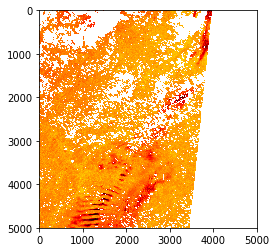

In [64]:
#multiply the two arrays together
#b10_clouds = b10*clouds_bin

b10_clouds = np.multiply(b10,clouds_bin)

b10_clouds = np.where(b10_clouds == 0, np.nan, b10_clouds)

lst_c = (b10_clouds*0.00341802 + 149) - 273.1

plt.imshow(lst_c, cmap = 'hot')

In [65]:
print(np.nanmin(b10_clouds))
print(np.nanmax(b10_clouds)) 

28522.0
47345.0


In [66]:
print(np.nanmin(lst_c))
print(np.nanmax(lst_c)) 

-26.611233560000016
37.72615689999998


(array([1.664800e+04, 3.209700e+04, 8.066300e+04, 2.074580e+05,
        8.738300e+05, 8.393484e+06, 4.393030e+06, 7.813000e+03,
        1.110000e+02, 4.000000e+01]),
 array([-26.61123356, -20.17749451, -13.74375547,  -7.31001642,
         -0.87627738,   5.55746167,  11.99120072,  18.42493976,
         24.85867881,  31.29241785,  37.7261569 ]),
 <a list of 10 Patch objects>)

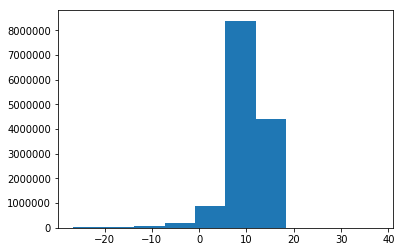

In [55]:
plt.hist(lst_c[~np.isnan(lst_c)])

# Write out to raster file

In [75]:
# Edit metadata like a dictionary in python:

out_meta = b10_file.meta.copy()
out_meta.update({'driver':'GTiff',
                 'width':b10_file.shape[1],
                 'height':b10_file.shape[0],
                 'count':1,
                 'dtype':'float64',
                 'crs':b10_file.crs, 
                 'transform':b10_file.transform,
                 'nodata':np.nan})
out_meta


{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': nan,
 'width': 5000,
 'height': 5000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(30.0, 0.0, 1034415.0,
        0.0, -30.0, 1364805.0)}

In [83]:
# then: save the index in format Geotiff using rasterio:

with rasterio.open(os.path.join(".", 'final_lst.tif'), 'w', **out_meta) as dst:
    dst.write_band(1, lst_c.astype(rasterio.float64))